In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Imports

In [2]:
from activation_functions import *
from optimizers import *
from layer import *
from variational_autoencoder import *
from loss import *
from mlp import *
from utils import *

# Load emojis

In [3]:
emoji_names = [
    "grinning",
    "smile",
    "laughing",
    "joy",
    "wink",
    "expressionless",
    "frown",
    "gasp",
    "disappointed",
    "angry",
]

emoji_size = (24, 24)
emoji_images = []

img = np.asarray(Image.open('emojis2.png').convert("L"))
emojis_per_row = img.shape[1] / emoji_size[1]
for i in range(len(emoji_names)):
    y = int((i // emojis_per_row) * emoji_size[0])
    x = int((i % emojis_per_row) * emoji_size[1])
    emoji_matrix = img[y:(y + emoji_size[1]), x:(x + emoji_size[0])] / 255
    emoji_vector = emoji_matrix.flatten()
    emoji_images.append(emoji_vector)


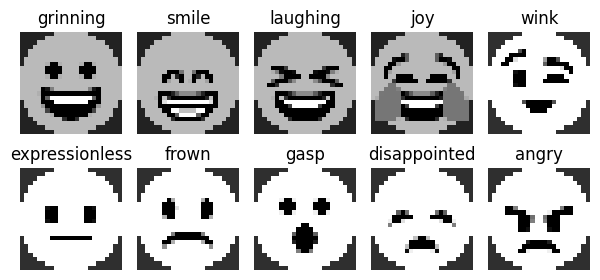

In [4]:
# Display emojis
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 3))

axes = axes.flatten()

# Loop through the emoji images and plot them in the subplots
for i, image in enumerate(emoji_images):
    # Reshape
    reshaped_image = image.reshape(emoji_size)

    # Plot the image in the corresponding subplot
    axes[i].imshow(reshaped_image, cmap='gray')
    axes[i].axis('off')
    
    # Add the emoji name as a label
    axes[i].set_title(emoji_names[i])

plt.tight_layout()
plt.show()

# VAE

In [5]:
# VAE parameters
INPUT_SIZE = emoji_size[0]*emoji_size[1]
LATENT_SIZE = 2
HIDDEN_SIZE = 100
HIDDEN_SIZE2 = 200
HIDDEN_SIZE3 = 300
EMOJIS_CHOSEN = len(emoji_images)
NOISE = None

## Train

In [6]:
emoji_indexes = np.array(np.arange(len(emoji_images)))
data = np.array(emoji_images)
dataset_input = data[emoji_indexes]
dataset_input_list = list(dataset_input)

optimizer = Adam(0.001)

encoder = MLP()
encoder.addLayer(Dense(inputDim=INPUT_SIZE, outputDim=HIDDEN_SIZE3, activation=ReLU(), optimizer=optimizer))
encoder.addLayer(Dense(inputDim=HIDDEN_SIZE3, outputDim=HIDDEN_SIZE2, activation=ReLU(), optimizer=optimizer))
encoder.addLayer(Dense(inputDim=HIDDEN_SIZE2, outputDim=HIDDEN_SIZE, activation=ReLU(), optimizer=optimizer))

sampler = Sampler(HIDDEN_SIZE, LATENT_SIZE, optimizer=optimizer)

decoder = MLP()
decoder.addLayer(Dense(inputDim=LATENT_SIZE, outputDim=HIDDEN_SIZE, activation=ReLU(), optimizer=optimizer))
decoder.addLayer(Dense(inputDim=HIDDEN_SIZE, outputDim=HIDDEN_SIZE2, activation=ReLU(), optimizer=optimizer))
decoder.addLayer(Dense(inputDim=HIDDEN_SIZE2, outputDim=HIDDEN_SIZE3, activation=ReLU(), optimizer=optimizer))
decoder.addLayer(Dense(inputDim=HIDDEN_SIZE3, outputDim=INPUT_SIZE, activation=Sigmoid(), optimizer=optimizer))

vae = VAE(encoder, sampler, decoder)

vae.train(dataset_input=dataset_input_list, loss=MSE(), epochs=1000, callbacks={})

### Original vs decoded comparison

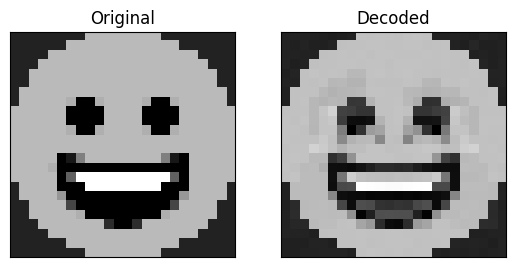

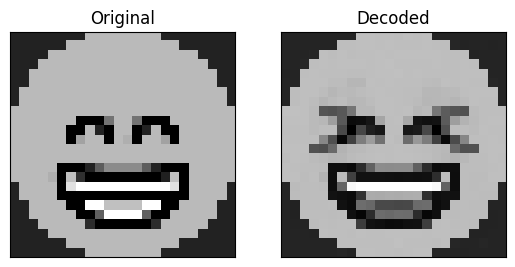

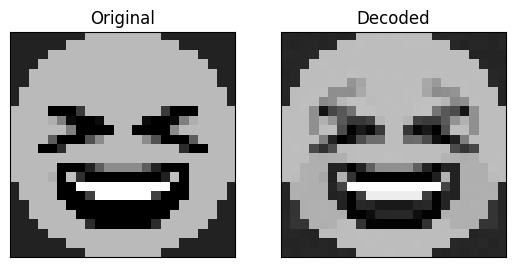

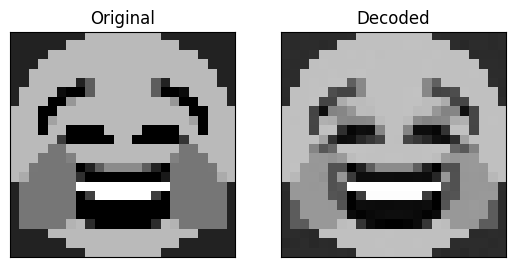

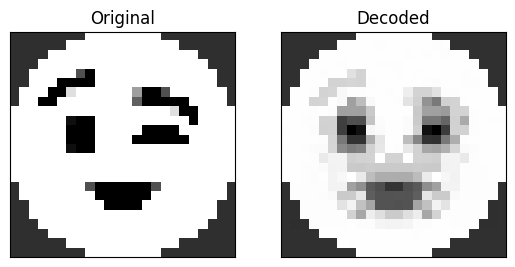

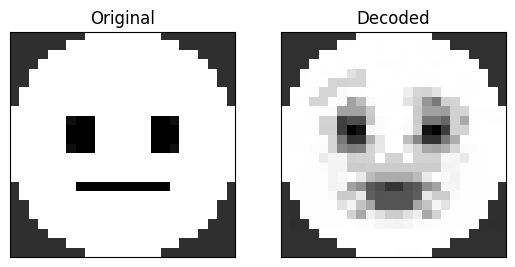

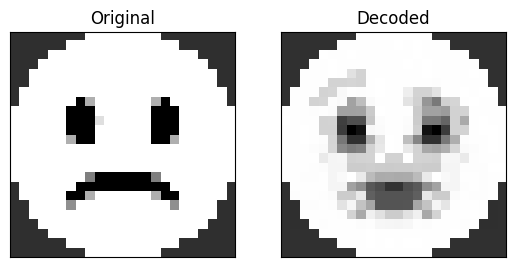

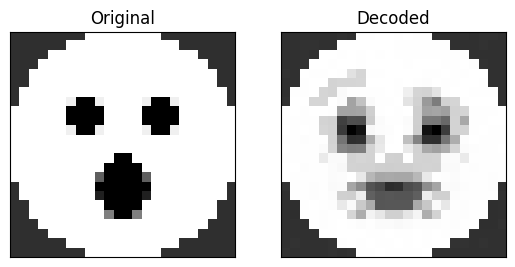

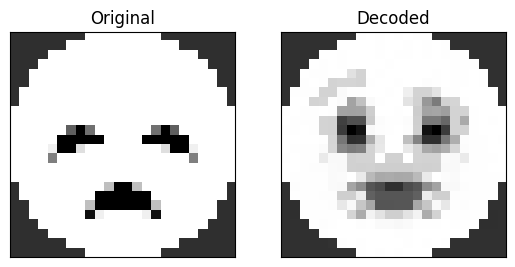

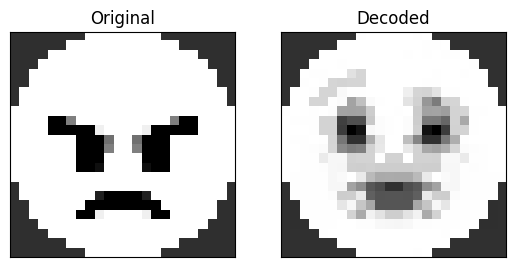

In [10]:
for i in range(len(dataset_input_list)):
    input_reshaped = np.reshape(dataset_input_list[i], (len(dataset_input_list[i]), 1))
    output = vae.feedforward(input_reshaped)
    plot_data(list(dataset_input)[i], output, emoji_size[0], emoji_size[1])

## New Samples Generator

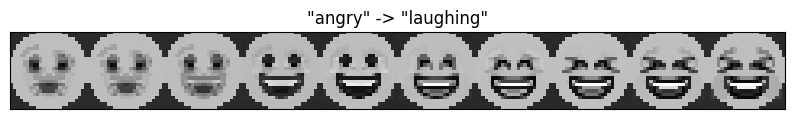

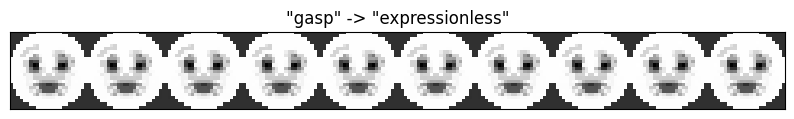

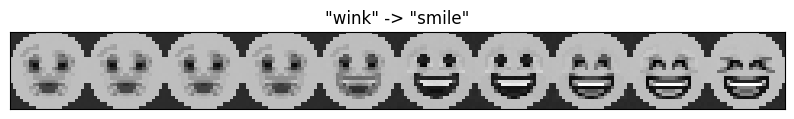

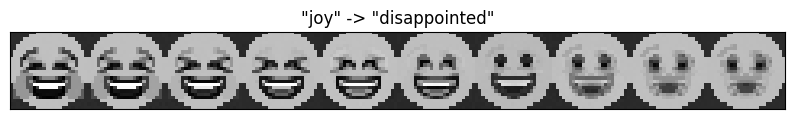

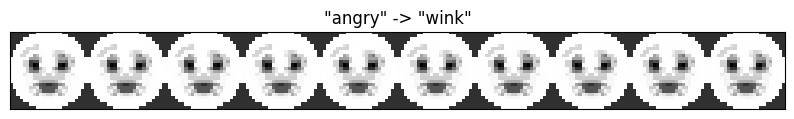

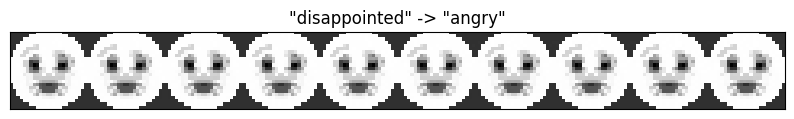

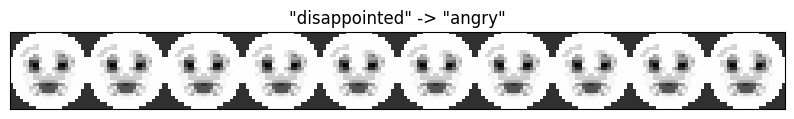

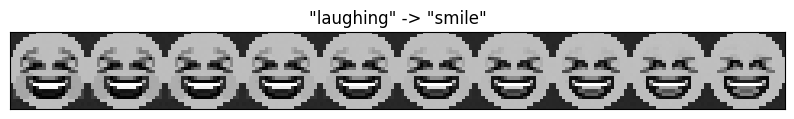

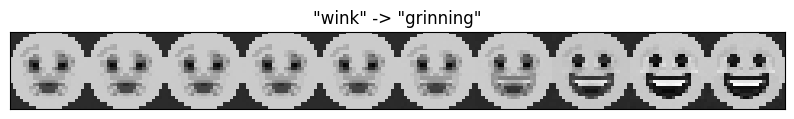

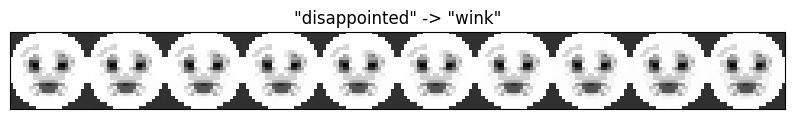

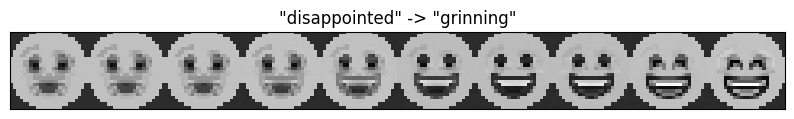

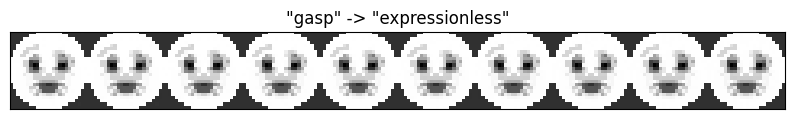

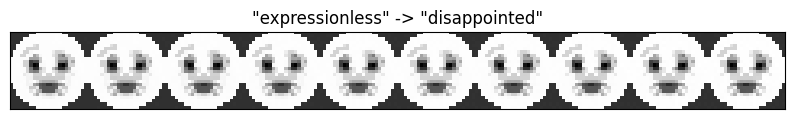

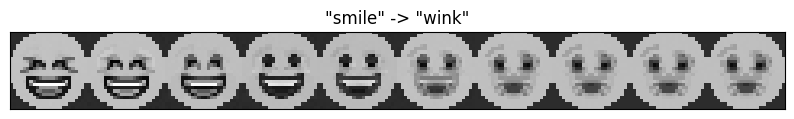

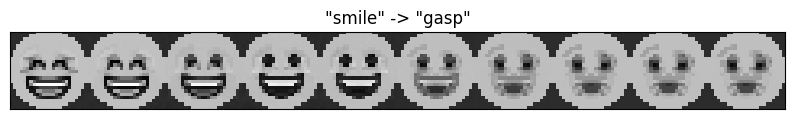

In [11]:
for _ in range(15):
    n = 10
    digit_size = emoji_size[0]
    images = np.zeros((emoji_size[0], emoji_size[1] * n))

    random_index1 = np.random.choice(emoji_indexes)
    input_reshaped1 = np.reshape(emoji_images[random_index1], (len(emoji_images[random_index1]), 1))
    vae.feedforward(input_reshaped1)
    img1 = vae.sampler.sample

    random_index2 = np.random.choice(emoji_indexes)
    while random_index1 == random_index2:
        random_index2 = np.random.choice(emoji_indexes)
    input_reshaped2 = np.reshape(emoji_images[random_index2], (len(emoji_images[random_index2]), 1))
    vae.feedforward(input_reshaped2)
    img2 = vae.sampler.sample
    
    for i in range(n):
        z = (img1 * (n - 1 - i) + img2 * i) / (n - 1)
        output = vae.decoder.feedforward(z)
        output = output.reshape(emoji_size[0], emoji_size[1])
        images[:, i * emoji_size[1]:(i + 1) * emoji_size[1]] = output

    plt.figure(figsize=(10, 10))
    plt.title(f"\"{emoji_names[random_index1]}\" "
                  f"-> \"{emoji_names[random_index2]}\"")
    plt.imshow(images, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


### Moving through the latent space

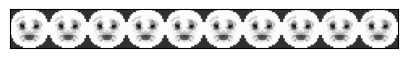

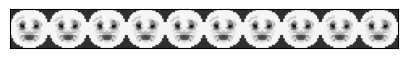

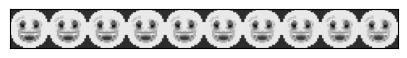

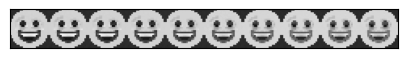

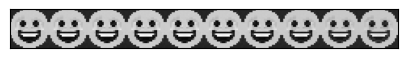

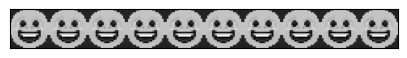

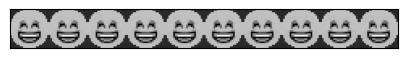

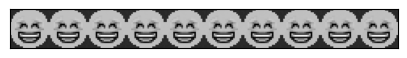

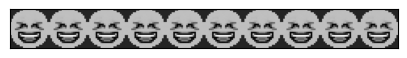

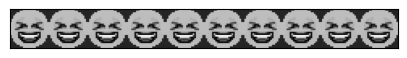

In [12]:
for j in range(10):
    n = 10
    digit_size = emoji_size[0]
    images = np.zeros((emoji_size[0], emoji_size[1] * n))

    random_index1 = np.random.choice(emoji_indexes)
    input_reshaped1 = np.reshape(emoji_images[random_index1], (len(emoji_images[random_index1]), 1))
    vae.feedforward(input_reshaped1)
    img1 = vae.sampler.sample

    random_index2 = np.random.choice(emoji_indexes)
    while random_index1 == random_index2:
        random_index2 = np.random.choice(emoji_indexes)
    input_reshaped2 = np.reshape(emoji_images[random_index2], (len(emoji_images[random_index2]), 1))
    vae.feedforward(input_reshaped2)
    img2 = vae.sampler.sample

    
    for i in range(n):
        z = np.array([i*0.2 - 0.5, j *0.2 - 0.5])
        #print(z)
        output = vae.decoder.feedforward(z)
        output = output.reshape(emoji_size[0], emoji_size[1])
        images[:, i * emoji_size[1]:(i + 1) * emoji_size[1]] = output

    plt.figure(figsize=(5, 5))
    plt.imshow(images, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()